# Ćwiczenie 3

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry Connect Four (czwórki).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four (ale, tak aby rozwiązanie miało ten sam interfejs co podany poniżej).

Implementację Minimax należy przetestować używając różną głębokość przeszukiwania. Implementacja Solvera musi zapewniać interfejs jak poniżej, ale można dodać dowolne metody prywatne oraz klasy wspomagające (jeżeli będą potrzebne).

Punktacja:
- Działająca metoda Minimax - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania **1.5pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów, bądź kilka przykładów 'z ręki'
- Jakość kodu **2pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [2]:
from typing import Tuple, List

from two_player_games.player import Player
from typing import Tuple, List, Optional

from two_player_games.player import Player
from two_player_games.games.connect_four import (
    ConnectFour,
    ConnectFourMove,
    ConnectFourState,)

from time import time

import matplotlib.pyplot as plt

Wielkość planszy

In [3]:
ROW_COUNT = 6
COLUMN_COUNT = 7

# implementacja

In [5]:
WIN_VALUE = 100
ENEMY_MULTIPLIER = -2.5
CONNECTED_FIELD_WEIGHTS = {0: 0, 1: 1, 2: 6, 3: 12}
DEPTH = 5

In [6]:
def find_last_element_in_line(line: List[Optional[Player]]): # not the best name
    try:
        return max(line.index(None) - 1, 0)
    except ValueError:
        return -1

class MinMaxSolver:
    def __init__(self, game: ConnectFour) -> None:
        self.game = game
        self._gmae_size = (len(game.state.fields), len(game.state.fields[0]))
        self.temporary_game_state = ConnectFourState(self._gmae_size)

    def evaluate_position(self, player: Player) -> float:
        position_score = 0.0

        if self.temporary_game_state.is_finished():
            if self.temporary_game_state.get_winner() == player:
                return WIN_VALUE
            return WIN_VALUE * ENEMY_MULTIPLIER

        position_score += self._evaluate_columns()

        position_score += self._evaluate_rows()

        position_score += self._evaluate_diagonal_positiv()

        position_score += self._evaluate_diagonal_negative()

        return position_score

    def get_best_move(self, with_alpha_beta: bool = True, depth: int = 3) -> int:
        self._copy_game_state_to_temporary(self.game.state)
        if with_alpha_beta:
            return self.alpha_beta(depth, -float("inf"), float("inf"), True)[0]
        return self.minimax(depth, -float("inf"), float("inf"), True)[0]

    def is_valid_move(self, col_index: int) -> bool:
        return (
            find_last_element_in_line(self.temporary_game_state.fields[col_index]) != -1
        )

    def minimax(
        self,
        depth,
        alpha: float,
        beta: float,
        is_maximizing_player: bool,
    ) -> Tuple[int, float]:
        move_evaluations = []
        if depth == 0 or self.temporary_game_state.is_finished():
            return (
                0,
                self.evaluate_position(self.game.state.get_current_player()),
            )
            
        start_game_state = ConnectFourState(
            self._gmae_size,
            self.temporary_game_state.get_current_player(),
            self.temporary_game_state.get_players()[-1],
            self.temporary_game_state.fields.copy(),
        )
        
        for colunm_index in range(len(self.game.state.fields)):
            if self.is_valid_move(colunm_index):
                
                self.temporary_game_state = self.temporary_game_state.make_move(
                    ConnectFourMove(colunm_index)
                )
                
                _, value = self.minimax(
                    depth - 1, alpha, beta, not is_maximizing_player
                )
                
                move_evaluations.append((colunm_index, value))
                
                self._copy_game_state_to_temporary(start_game_state)
                
        move_evaluations.sort(key=lambda x: x[1], reverse=is_maximizing_player)
        return move_evaluations[0]

    def alpha_beta(
        self,
        depth,
        alpha: float,
        beta: float,
        is_maximizing_player: bool,
    ) -> Tuple[int, float]:
        if depth == 0 or self.temporary_game_state.is_finished():
            return (
                None,
                self.evaluate_position(self.game.state.get_current_player()),
            )
            
        start_game_state = ConnectFourState(
            self._gmae_size,
            self.temporary_game_state.get_current_player(),
            self.temporary_game_state.get_players()[-1],
            self.temporary_game_state.fields.copy(),
        )
        
        best_move = 0
        for colunm_index in range(len(self.game.state.fields)):
            if self.is_valid_move(colunm_index):
                
                value = self._test_move_alpha_beta(depth, alpha, beta, is_maximizing_player, colunm_index)
                
                if is_maximizing_player:
                    best_move = colunm_index if alpha < value else best_move
                    alpha = max(alpha, value)
                    if alpha >= beta:
                        return (colunm_index, beta)
                else:
                    best_move = colunm_index if beta > value else best_move
                    beta = min(beta, value)
                    if beta <= alpha:
                        return (colunm_index, alpha)

                self._copy_game_state_to_temporary(start_game_state)
        return (best_move, alpha) if is_maximizing_player else (best_move, beta)
    
    def _test_move_alpha_beta(self,
        depth,
        alpha: float,
        beta: float,
        is_maximizing_player: bool,
        move_index: int) -> float:
        self.temporary_game_state = self.temporary_game_state.make_move(
                ConnectFourMove(move_index)
            )
        _, value = self.alpha_beta(
            depth - 1, alpha, beta, not is_maximizing_player
        )
        return value
        

    def _copy_game_state_to_temporary(self, saved_state: ConnectFourState):
        self.temporary_game_state = ConnectFourState(
            self._gmae_size,
            saved_state.get_current_player(),
            saved_state.get_players()[-1],
            saved_state.fields.copy(),
        )

    def _evaluate_one_column(self, column: List[Optional[Player]], player: Player):
        start_index = find_last_element_in_line(column)
        researched_space = column[start_index]
        if researched_space is None:
            return 0
        number_of_player_spaces = 0
        while start_index >= 0 and column[start_index].char == researched_space.char:
            number_of_player_spaces += 1
            start_index -= 1
        return number_of_player_spaces * (
            1 if researched_space.char == player.char else ENEMY_MULTIPLIER
        )

    def _evaluate_non_column_line(
        self, line: List[Optional[Player]], player: Player
    ) -> float:
        row_value = 0
        if None not in line:
            return 0
        for frame_number in range(len(line) - 4 + 1):
            temporary_frame = line[frame_number : frame_number + 4]
            if self._should_line_not_be_evaluated(temporary_frame, player):
                continue
            if player not in temporary_frame:
                row_value += (
                    CONNECTED_FIELD_WEIGHTS[
                        len(temporary_frame) - temporary_frame.count(None)
                    ]
                    * ENEMY_MULTIPLIER
                )
                continue
            row_value += CONNECTED_FIELD_WEIGHTS[temporary_frame.count(player)]
        return row_value

    def _should_line_not_be_evaluated(self, line: List[Player], player: Player):
        return (
            None not in line
            or (player in line and self.game.state.get_players()[-1] in line)
            or line.count(None) == len(line)
        )

    def _evaluate_columns(self) -> float:
        evaluation = 0.0
        for line in self.temporary_game_state.fields:
            evaluation += self._evaluate_one_column(
                line, self.game.state.get_current_player()
            )
        return evaluation

    def _evaluate_rows(self) -> float:
        evaluation = 0.0
        for row_num in range(self._gmae_size[1]):
            evaluation += self._evaluate_non_column_line(
                [column[row_num] for column in self.temporary_game_state.fields],
                self.game.state.get_current_player(),
            )
        return evaluation

    def _evaluate_diagonal_positiv(self) -> float:
        evaluation = 0.0
        for column_num in range(3, self._gmae_size[0]):
            evaluation += self._evaluate_non_column_line(
                [
                    self.temporary_game_state.fields[column_num - i][i]
                    for i in range(column_num)
                ],
                self.game.state.get_current_player(),
            )
        return evaluation

    def _evaluate_diagonal_negative(self) -> float:
        evaluation = 0.0
        for column_num in range(self._gmae_size[0] - 3):
            evaluation += self._evaluate_non_column_line(
                [
                    self.temporary_game_state.fields[column_num + i][i]
                    for i in range(column_num)
                ],
                self.game.state.get_current_player(),
            )
        return evaluation

W implementacji widzimy dwie metody minmax i alphabeta. W pierwszej z tych metod zaimplementowany jest algorytm minmax bez przycinania alpha beta a w drugiej metodzie te przycinanie jest zaimplementowane. Dodatkowo można by było przekształcić algorytm tak aby przyjmował odpowiednią funkcję ewaluacyjną jako lambdę, w ten sposób algorytm byłby bardziej reużywalny (nie zrobiłem tego poniewaz chciałem trzymać się dostarczonego szkieletu). W implementacji jest sporo pętli i warunków if i próbowałem od tego uciec ale niestety nie wszędzie znalazłem rozwiązanie. Aby obliczyć wartość funkcji ewaluacji dla danej pozycji musimy, dany róch wykonać na tymczasowej planszy, a następnie dokonać ewaluacji tej planszy. Zliczamy liczbę pól danego koloru w okolicach których można postawić pionek, a następnie tą ilość przekształcamy na punkty przy pomocy słownika wag i jeżeli dane pionki nie są gracza który aktualnie wykonuje ruch to mnożymy ten wynik przez ujemną wartość. Dodatkowo mamy oddzielną wagę jeżeli gra została wygrana.

# Przykład gry

In [7]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)
while not game.is_finished():
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
print(game)
print(f'Winner: {game.get_winner().char}')

Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]
Winner: a


# Różne Wagi

Wagi wygranej nie za bardzo trzeba dostrajać, ale warto by było aby była całkiem spora

In [60]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to zestaw wag: {0: 0, 1: 1, 2: 3, 3: 12}")
print("b to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 12}")

solver = MinMaxSolver(game)
while not game.is_finished():
    CONNECTED_FIELD_WEIGHTS = {0: 0, 1: 1, 2: 3, 3: 12}
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))
    if game.is_finished():
        break
    CONNECTED_FIELD_WEIGHTS = {0: 0, 1: 1, 2: 6, 3: 12}
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))
print(game)
print(f'Winner: {game.get_winner().char}')

a to zestaw wag: {0: 0, 1: 1, 2: 3, 3: 12}
b to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 12}
Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][a][b][ ][ ][ ]
[ ][ ][a][b][b][ ][ ]
[ ][a][b][b][a][b][ ]
[a][b][a][b][a][a][ ]
Winner: b


In [61]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 12}")
print("b to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 18}")

solver = MinMaxSolver(game)
while not game.is_finished():
    CONNECTED_FIELD_WEIGHTS = {0: 0, 1: 1, 2: 6, 3: 12}
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))
    if game.is_finished():
        break
    CONNECTED_FIELD_WEIGHTS = {0: 0, 1: 1, 2: 6, 3: 18}
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))
print(game)
print(f'Winner: {game.get_winner().char}')

a to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 12}
b to zestaw wag: {0: 0, 1: 1, 2: 6, 3: 18}
Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]
Winner: a


# Porównanie MinMax z i bez przycinania alpha-beta

In [20]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)

for i in range(10):
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))

start = time()
move = solver.get_best_move()
print(f'Czas obliczania z przycinaniem: {time() - start}')

start = time()
move = solver.get_best_move(False)
print(f'Czas obliczania bez przycinania: {time() - start}')

Czas obliczania z przycinaniem: 0.027407169342041016
Czas obliczania bez przycinania: 0.04645562171936035


In [19]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)

for i in range(10):
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))

start = time()
move = solver.get_best_move(depth=5)
print(f'Czas obliczania z przycinaniem: {time() - start}')

start = time()
move = solver.get_best_move(False, depth=5)
print(f'Czas obliczania bez przycinania: {time() - start}')

Czas obliczania z przycinaniem: 0.42548108100891113
Czas obliczania bez przycinania: 2.0333712100982666


In [63]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)
is_pruning = False
while not game.is_finished():
    move = solver.get_best_move(is_pruning)
    game.make_move(ConnectFourMove(move[0]))
    is_pruning = not is_pruning
print(game)
print(f'Winner: {game.get_winner().char}')

game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)
is_pruning = True
while not game.is_finished():
    move = solver.get_best_move(is_pruning)
    game.make_move(ConnectFourMove(move[0]))
    is_pruning = not is_pruning
print(game)
print(f'Winner: {game.get_winner().char}')

Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]
Winner: a
Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]
Winner: a


# Test głębokości

Took: 0.0011508464813232422 for depth: 1
Took: 0.004107475280761719 for depth: 2
Took: 0.014369726181030273 for depth: 3
Took: 0.049698591232299805 for depth: 4
Took: 0.22799897193908691 for depth: 5
Took: 0.8652896881103516 for depth: 6
Took: 2.501167058944702 for depth: 7
Took: 10.534006357192993 for depth: 8


Text(0, 0.5, 'Czas [s]')

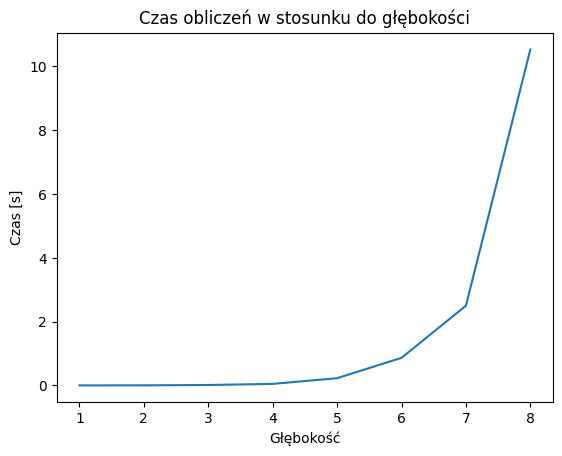

In [64]:
dephts = [1, 2, 3, 4, 5, 6, 7, 8]
times = []

p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)

for i in range(10):
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move[0]))

for depht in dephts:
    start = time()
    move = solver.get_best_move(depth=depht)
    times.append(time() - start)
    print(f'Took: {times[-1]} for depth: {depht}')

plt.plot(dephts, times)
plt.title("Czas obliczeń w stosunku do głębokości")
plt.xlabel("Głębokość")
plt.ylabel("Czas [s]")

Czas przetwarzania róchu zwiększa się średno 3-4 krotnie wraz ze wzrostem głębokości. Wyjątkiem jest wzrost z głębokości 4 na 5 gdzie czas wydłuża się około 5 krotnie. 

In [68]:
p1 = Player("4")
p2 = Player("3")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

deepths = [4, 3]
depth_index = 0

solver = MinMaxSolver(game)
while not game.is_finished():
    move = solver.get_best_move(depth=deepths[depth_index%2])
    game.make_move(ConnectFourMove(move[0]))
    depth_index += 1
print(game)
print(f'Winner depth: {game.get_winner().char}')

Current player: 3
[4][3][3][4][4][ ][ ]
[3][3][4][4][3][ ][ ]
[4][4][3][3][4][4][ ]
[3][3][4][4][4][3][ ]
[4][3][3][4][3][4][ ]
[3][4][4][3][3][3][4]
Winner depth: 4


In [72]:
p1 = Player("4")
p2 = Player("5")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

deepths = [4, 5]
depth_index = 0

solver = MinMaxSolver(game)
while not game.is_finished():
    move = solver.get_best_move(depth=deepths[depth_index%2])
    game.make_move(ConnectFourMove(move[0]))
    depth_index += 1
print(game)
print(f'Winner depth: {game.get_winner().char}')

Current player: 4
[ ][4][4][5][ ][4][ ]
[ ][4][5][5][5][4][ ]
[ ][5][4][4][4][5][ ]
[5][4][5][5][5][4][ ]
[4][4][5][4][4][5][ ]
[5][4][5][5][5][4][ ]
Winner depth: 5


In [71]:
p1 = Player("5")
p2 = Player("6")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

deepths = [5, 6]
depth_index = 0

solver = MinMaxSolver(game)
while not game.is_finished():
    move = solver.get_best_move(depth=deepths[depth_index%2])
    game.make_move(ConnectFourMove(move[0]))
    depth_index += 1
print(game)
print(f'Winner depth: {game.get_winner().char}')

Current player: 5
[5][ ][5][6][6][5][6]
[6][ ][6][5][5][6][5]
[5][ ][5][6][6][5][6]
[6][ ][6][5][5][6][5]
[5][6][5][6][6][5][6]
[6][5][6][5][5][5][6]
Winner depth: 6


Dla głębokości 1, 2, 3 występuje zwasze remis, bez różnicy na kolejność, natomiast dla głębokości 3 i 4 jeżeli 4 rozpoczyna grę to wygrywa w przeciwnym razie wystepuje remis. Natomiast dla głębokości powyżej 4 zawsze wygrywa większa głębokość. Z tego wynika że njbardziej optymalną głębokością jest głębokość 5. Wynika to z faktu że dla tej głębokości mamy duże prawdopodobieństwo wygrnia, ale zarazem may prawie niezauważalny dla człowieka czas obliczń (jeżeli chcemy zastosować go jako przeciwnika dla graczy).

# Rózne wagi reakcji na przeciwnika

In [21]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to waga -1.5")
print("b to waga -2.5")

solver = MinMaxSolver(game)
while not game.is_finished():
    ENEMY_MULTIPLIER = -1.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
    if game.is_finished():
        break
    ENEMY_MULTIPLIER = -2.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
print(game)
print(f'Winner: {game.get_winner().char}')

a to waga -1.5
b to waga -2.5
Current player: a
[b][a][b][b][a][b][b]
[a][b][a][a][b][a][a]
[b][a][b][b][b][a][b]
[a][b][a][a][a][b][a]
[b][a][b][b][a][b][b]
[a][a][b][a][a][b][a]


AttributeError: 'NoneType' object has no attribute 'char'

In [20]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to waga -40")
print("b to waga -2.5")

solver = MinMaxSolver(game)
while not game.is_finished():
    ENEMY_MULTIPLIER = -40
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
    if game.is_finished():
        break
    ENEMY_MULTIPLIER = -2.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
print(game)
print(f'Winner: {game.get_winner().char}')

a to waga -40
b to waga -2.5
Current player: a
[b][ ][b][b][a][b][b]
[a][ ][a][b][a][a][a]
[b][ ][b][a][a][b][b]
[a][ ][a][b][b][a][a]
[b][b][b][b][a][b][b]
[a][a][a][b][a][a][a]
Winner: b


In [22]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to waga 1.5")
print("b to waga -2.5")

solver = MinMaxSolver(game)
while not game.is_finished():
    ENEMY_MULTIPLIER = 1.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
    if game.is_finished():
        break
    ENEMY_MULTIPLIER = -2.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
print(game)
print(f'Winner: {game.get_winner().char}')

a to waga 1.5
b to waga -2.5
Current player: a
[a][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][ ]
[a][ ][ ][a][b][a][ ]
[b][ ][ ][b][a][a][ ]
[a][ ][ ][a][b][a][ ]
[b][b][b][b][a][b][ ]
Winner: b


In [24]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

print("a to waga -1.3")
print("b to waga -2.5")

solver = MinMaxSolver(game)
while not game.is_finished():
    ENEMY_MULTIPLIER = -2.5
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
    if game.is_finished():
        break
    ENEMY_MULTIPLIER = -1.3
    move = solver.get_best_move()
    game.make_move(ConnectFourMove(move))
print(game)
print(f'Winner: {game.get_winner().char}')

a to waga -1.3
b to waga -2.5
Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]
Winner: a


# Więcej przykładowych gier z finalnymi parametrami

In [35]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)

while not game.is_finished():
    move = solver.get_best_move()
    # print(move)
    game.make_move(ConnectFourMove(move))
print(game)

Current player: b
[a][b][ ][a][b][ ][ ]
[b][a][a][a][b][ ][ ]
[b][a][b][b][b][ ][ ]
[a][b][a][a][a][ ][ ]
[b][a][b][a][b][a][ ]
[a][b][a][a][b][b][ ]


In [38]:
p1 = Player("a")
p2 = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=p1, second_player=p2)

solver = MinMaxSolver(game)
game.make_move(ConnectFourMove(4))
game.make_move(ConnectFourMove(4))
game.make_move(ConnectFourMove(6))
game.make_move(ConnectFourMove(1))

while not game.is_finished():
    move = solver.get_best_move()
    # print(move)
    game.make_move(ConnectFourMove(move))
print(game)

Current player: a
[ ][ ][ ][a][b][ ][ ]
[ ][ ][ ][b][a][ ][ ]
[a][ ][b][a][b][ ][ ]
[b][b][b][a][a][ ][ ]
[a][a][b][a][b][ ][ ]
[b][b][a][b][a][ ][a]
